In [1]:
import numpy as np
import pandas as pd
from pandas import Series

import pathlib
from glob import glob
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,BatchNormalization
from tensorflow.python.keras.models import Sequential, Model
from keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers
from keras.applications.xception import Xception
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, BackupAndRestore
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras import regularizers

In [2]:
# Connecting to Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/Intel_images_psnr.zip

Streaming output truncated to the last 5000 lines.
  inflating: content/drive/MyDrive/Intel_images_psnr/train/mountain/6667_rlt.png  
  inflating: content/drive/MyDrive/Intel_images_psnr/train/mountain/15155_rlt.png  
  inflating: content/drive/MyDrive/Intel_images_psnr/train/mountain/5561_rlt.png  
  inflating: content/drive/MyDrive/Intel_images_psnr/train/mountain/8564_rlt.png  
  inflating: content/drive/MyDrive/Intel_images_psnr/train/mountain/313_rlt.png  
  inflating: content/drive/MyDrive/Intel_images_psnr/train/mountain/4513_rlt.png  
  inflating: content/drive/MyDrive/Intel_images_psnr/train/mountain/2769_rlt.png  
  inflating: content/drive/MyDrive/Intel_images_psnr/train/mountain/8532_rlt.png  
  inflating: content/drive/MyDrive/Intel_images_psnr/train/mountain/14849_rlt.png  
  inflating: content/drive/MyDrive/Intel_images_psnr/train/mountain/9799_rlt.png  
  inflating: content/drive/MyDrive/Intel_images_psnr/train/mountain/12776_rlt.png  
  inflating: content/drive/MyDrive

In [38]:
# Data paths in drive
src_path_train = "/content/content/drive/MyDrive/Intel_images_psnr/train"
src_path_test = "/content/content/drive/MyDrive/Intel_images_psnr/test"
src_path_val = "/content/content/drive/MyDrive/Intel_images_psnr/val"

# Initializing IDG instances for training and testing

train_IDG = ImageDataGenerator(rescale=1./255,
    rotation_range=2,
    zoom_range=0.1,
    horizontal_flip=True)

test_IDG = ImageDataGenerator(rescale= 1./255.0)

In [39]:
batch_size = 32
train_generator = train_IDG.flow_from_directory(
    src_path_train,
    target_size=(150,150),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    seed=42)

validation_generator = train_IDG.flow_from_directory(
    src_path_val, 
    target_size=(150,150),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    seed=42)

test_generator = test_IDG.flow_from_directory(
    src_path_test,
    target_size=(150,150),
    color_mode='rgb',
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    seed = 42)

Found 11224 images belonging to 6 classes.
Found 2810 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [60]:
model = tf.keras.applications.mobilenet.MobileNet(
    input_shape=(150,150, 3),
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    classes=6,
    classifier_activation='softmax')

model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 75, 75, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 75, 75, 32)       128       
 ation)                                         

In [61]:
from keras import Sequential

# for layer in model.layers:
#   layer.trainable = False

model_2=Sequential()
#Add the Dense layers along with activation and batch normalization
model_2.add(model)
model_2.add(Flatten())

rn=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05,seed=42)
# #Add the Dense layers along with activation and batch normalization
# model_2.add(Dense(4096,activation=('relu')))
# model_2.add(Dense(2048,activation=('relu')))
model_2.add(Dense(256,activation=('relu'),kernel_initializer=rn))
# model_2.add(Dense(1024,activation=('relu'))) 
# model_2.add(Dropout(.4, seed=42))
model_2.add(Dense(256,activation=('relu'),kernel_initializer=rn)) 


# model_2.add(Dense(2048,activation=('relu'), kernel_regularizer=regularizers.L2(l2=0.01))) 
# model_2.add(Dropout(.3, seed=42))#Adding a dropout layer that will randomly drop 50% of the weights
# model_2.add(Dense(1024,activation=('relu'), kernel_regularizer=regularizers.L2(l2=0.01)))
# model_2.add(Dropout(.2, seed=42))
model_2.add(Dense(6,activation=('softmax'),kernel_initializer=rn)) #This is the classification layer

In [62]:
model_2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 16384)             0         
                                                                 
 dense_21 (Dense)            (None, 256)               4194560   
                                                                 
 dense_22 (Dense)            (None, 256)               65792     
                                                                 
 dense_23 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 7,490,758
Trainable params: 7,468,870
Non-trainable params: 21,888
_______________________________________

In [63]:
from keras.optimizers import SGD,Adam
# from tensorflow.keras.optimizers.legacy import SGD
learn_rate=.01

sgd = tf.keras.optimizers.legacy.SGD(lr=learn_rate,momentum=.9,decay=0.1)
adam = Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)

In [64]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=4, verbose=1, factor=0.5, min_lr=0.00001,min_delta=0.001)
early_stopping_monitor = EarlyStopping(patience=7, monitor='val_accuracy', restore_best_weights=True)

In [65]:
model_2.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [66]:
history = model_2.fit_generator(
              train_generator,
              steps_per_epoch = train_generator.samples // batch_size,
              validation_data = validation_generator, 
              validation_steps = validation_generator.samples // batch_size,
              callbacks=[learning_rate_reduction, early_stopping_monitor],
              epochs = 25,
              shuffle = True)

<ipython-input-66-6e98b0b73e99>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_2.fit_generator(


Epoch 1/25
350/350 [==============================] - 108s 300ms/step - loss: 1.6443 - accuracy: 0.5531 - val_loss: 0.8059 - val_accuracy: 0.6882 - lr: 0.0100
Epoch 2/25
350/350 [==============================] - 98s 280ms/step - loss: 0.7323 - accuracy: 0.7228 - val_loss: 0.6452 - val_accuracy: 0.7622 - lr: 0.0100
Epoch 3/25
350/350 [==============================] - 100s 285ms/step - loss: 0.5948 - accuracy: 0.7922 - val_loss: 0.5509 - val_accuracy: 0.8039 - lr: 0.0100
Epoch 4/25
350/350 [==============================] - 97s 278ms/step - loss: 0.5398 - accuracy: 0.8090 - val_loss: 0.5355 - val_accuracy: 0.8053 - lr: 0.0100
Epoch 5/25
350/350 [==============================] - 91s 261ms/step - loss: 0.5055 - accuracy: 0.8236 - val_loss: 0.5151 - val_accuracy: 0.8211 - lr: 0.0100
Epoch 6/25
350/350 [==============================] - 94s 270ms/step - loss: 0.4690 - accuracy: 0.8309 - val_loss: 0.4988 - val_accuracy: 0.8240 - lr: 0.0100
Epoch 7/25
350/350 [==============================

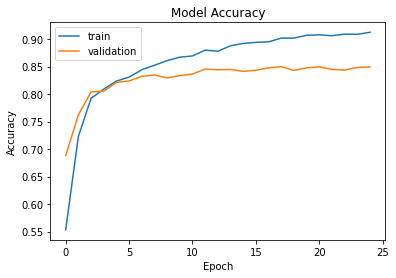

In [67]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

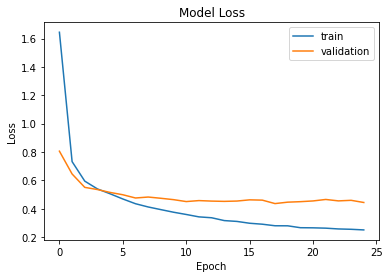

In [68]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [69]:
evaluate = model_2.evaluate(test_generator)
print(evaluate)

3000/3000 [==============================] - 22s 7ms/step - loss: 0.4560 - accuracy: 0.8497
[0.456017404794693, 0.8496666550636292]


In [70]:
print('The testing accuracy is :',evaluate[1]*100, '%')

The testing accuracy is : 84.96666550636292 %


In [71]:
model_2.save("MobileNet_intel_psnr.h5")